In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.data as data
import numpy as np

In [3]:
road_profile_0 = pd.read_csv("data/útprofil_X_bal.csv", sep=';')
road_profile_1 = pd.read_csv("data/útprofil_X_jobb.csv", sep=';')

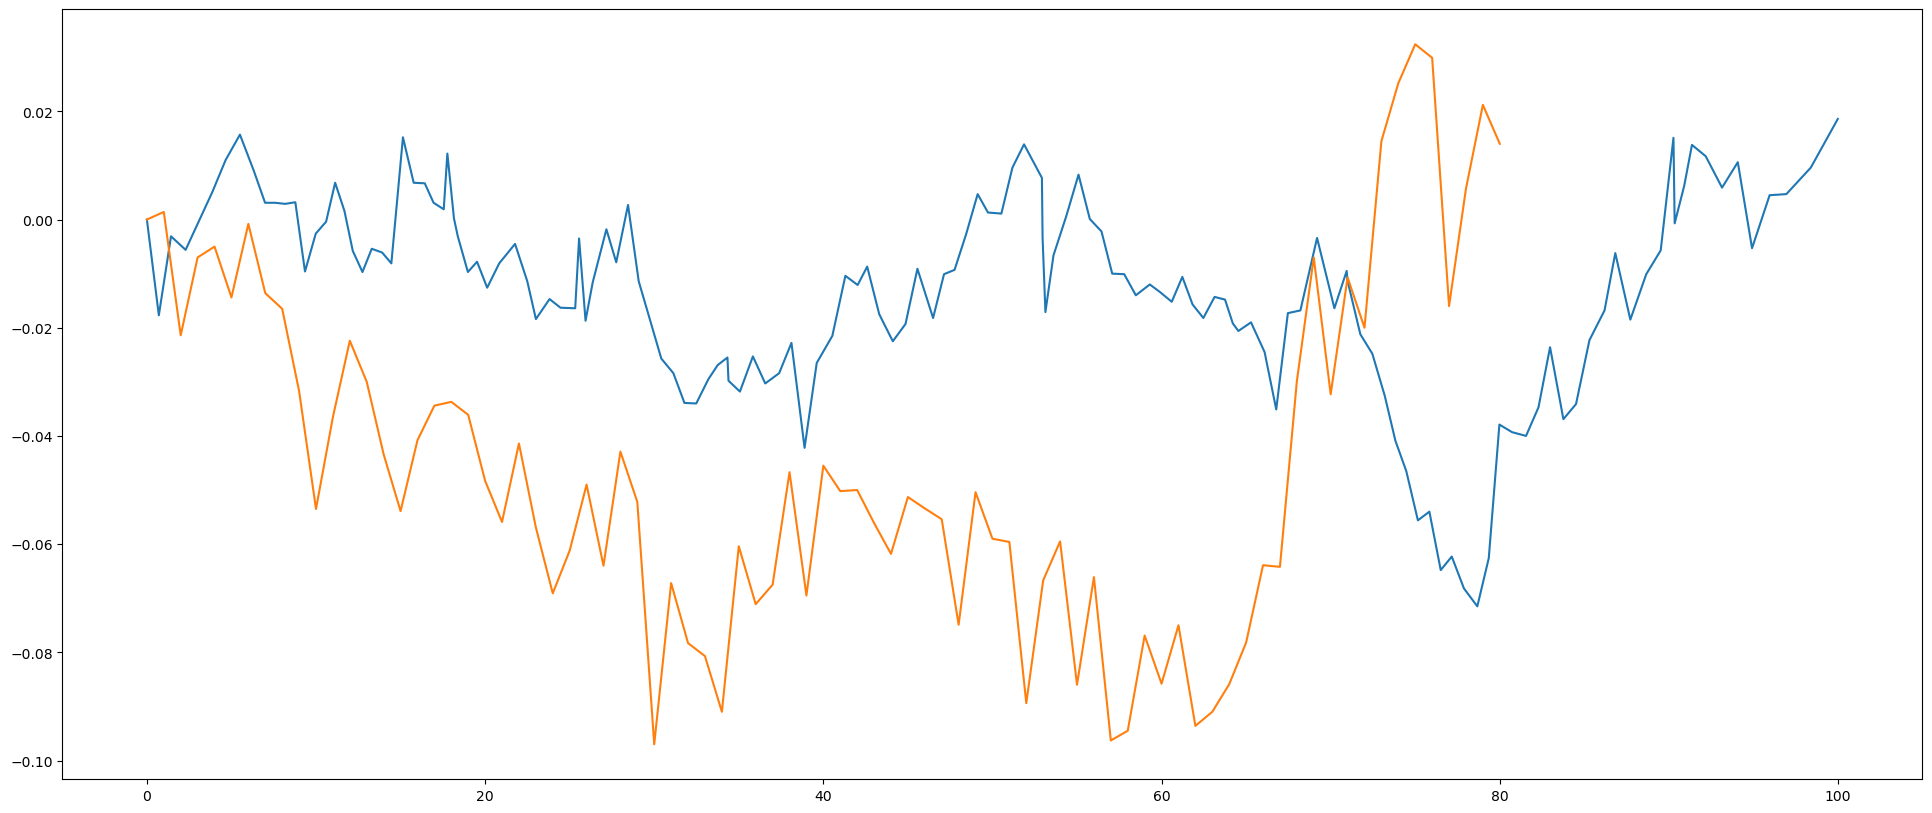

In [23]:
plt.figure(figsize=(24,10))
plt.plot(road_profile_0['X'], road_profile_0['Z'])
plt.plot(road_profile_1['Z'])

In [63]:
class RoadProfileEstimator(nn.Module):
    def __init__(self, hidden_layers=128):
        super().__init__()
        self.cnt_hidden_layers = 128
        self.lstm_c0 = nn.LSTMCell(1, self.cnt_hidden_layers)
        self.lstm_c1 = nn.LSTMCell(self.cnt_hidden_layers, self.cnt_hidden_layers)
        self.fc = nn.Linear(self.cnt_hidden_layers, 1)
        
    def forward(self, x, look=0):
        outputs = []
        h_t0 = torch.zeros(x.size(0), self.cnt_hidden_layers, dtype=torch.float32)
        c_t0 = torch.zeros(x.size(0), self.cnt_hidden_layers,dtype=torch.float32)
        h_t1 = torch.zeros(x.size(0), self.cnt_hidden_layers,dtype=torch.float32)
        c_t1 = torch.zeros(x.size(0), self.cnt_hidden_layers,dtype=torch.float32)
        for input_step in x.split(1, dim=1):
            h_t0, c_t0 = self.lstm_c0(input_step, (h_t0, c_t0))
            h_t1, c_t1 = self.lstm_c1(h_t0, (h_t1, c_t1))
            output = self.fc(h_t1)
            outputs += [output]
        for i in range(look):
            h_t0, c_t0 = self.lstm_c0(output, (h_t0, c_t0))
            h_t1, c_t1 = self.lstm_c1(h_t0, (h_t1, c_t1))
            output = self.fc(h_t1)
            outputs += [output]
        outputs = torch.cat(outputs, dim=1)
        return outputs

In [103]:
model = RoadProfileEstimator()
criterion = nn.MSELoss()
# use LBFGS as optimizer since we can load the whole data to train
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.05)

print(road_profile_0['Z'].shape)
print(road_profile_1['Z'].shape)

CNT_EPOCHS = 145
data = np.array([
    road_profile_0['Z'].to_numpy()[:81], 
    road_profile_1['Z'].to_numpy()[:81],
    road_profile_1['Z'].to_numpy()[-81:]
])
x = torch.Tensor(data[:, :-1])
target = torch.Tensor(data[:, 1:])
for i in range(CNT_EPOCHS):
    print('STEP: ', i)
    def closure():
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, target)
        print('loss:', loss.item())
        loss.backward()
        torch.nn.utils.clip_grad_norm(model.parameters(), 2.5)
        return loss
    optimizer.step(closure)

(148,)
(81,)
STEP:  0
loss: 0.010859633795917034
loss: 0.01051951665431261
loss: 0.009591486304998398


C:\Users\keret\AppData\Local\Temp\ipykernel_48052\2432433865.py:25: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 2.5)


loss: 0.008751949295401573
loss: 0.007992924191057682
loss: 0.007307032123208046
loss: 0.006687495391815901
loss: 0.006128092762082815
loss: 0.00562315434217453
loss: 0.005167501512914896
loss: 0.004756432957947254
loss: 0.004385664127767086
loss: 0.004051314201205969
loss: 0.0037498597521334887
loss: 0.0034781075082719326
loss: 0.003233167575672269
loss: 0.0030124227050691843
loss: 0.0028135059401392937
loss: 0.0026342759374529123
loss: 0.002472797641530633
STEP:  1
loss: 0.0023273250553756952
loss: 0.0021962798200547695
loss: 0.002078235847875476
loss: 0.0019719081465154886
loss: 0.0018761365208774805
loss: 0.00178987393155694
loss: 0.001712178229354322
loss: 0.0016421973705291748
loss: 0.0015791656915098429
loss: 0.0015223922673612833
loss: 0.001471254276111722
loss: 0.0014251911779865623
loss: 0.0013836977304890752
loss: 0.0013463193317875266
loss: 0.001312645967118442
loss: 0.0012823095312342048
loss: 0.0012549769598990679
loss: 0.0012303496478125453
loss: 0.001208158559165895
los

In [104]:
with torch.no_grad():
    future = 100
    pred = model(torch.Tensor(data[1, :-1]).unsqueeze(0), look=future)
    y = pred.detach().numpy()

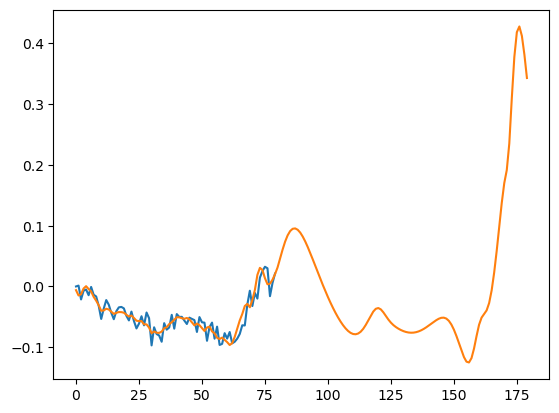

In [105]:
plt.plot(data[1, :-1], )
plt.plot(y.T)

In [106]:
with torch.no_grad():
    future = 100
    pred = model(torch.Tensor(data[1, :10]).unsqueeze(0), look=future)
    y = pred.detach().numpy()

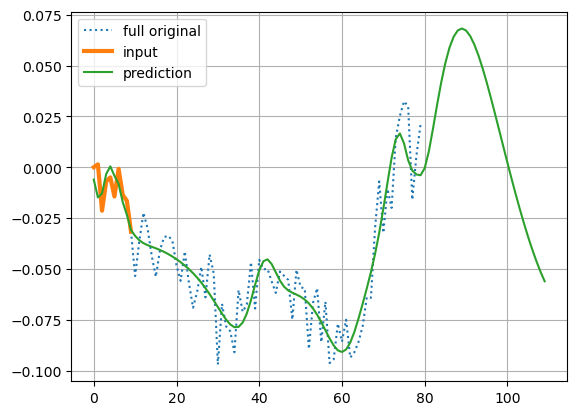

In [114]:
plt.plot(data[1, :-1], linestyle='dotted', label='full original')
plt.plot(data[1, :10], linewidth=3, label='input')
plt.plot(y.T, label='prediction')
plt.legend()
plt.grid()

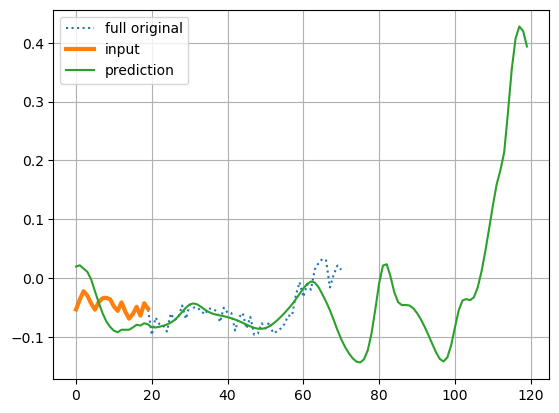

In [118]:
with torch.no_grad():
    future = 100
    pred = model(torch.Tensor(data[1, 10:30]).unsqueeze(0), look=future)
    y = pred.detach().numpy()
plt.plot(data[1, 10:], linestyle='dotted', label='full original')
plt.plot(data[1, 10:30], linewidth=3, label='input')
plt.plot(y.T, label='prediction')
plt.legend()
plt.grid()

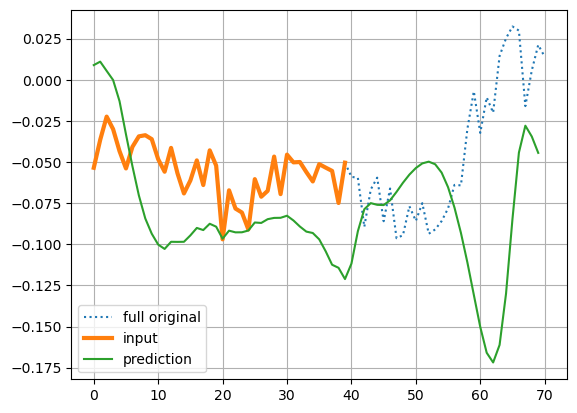

In [131]:
with torch.no_grad():
    future = 30
    pred = model(torch.Tensor(data[2, 10:50]).unsqueeze(0), look=future)
    y = pred.detach().numpy()
noise = np.random.weibull(250, len(y)) - 1.0
y = y.T + noise
plt.plot(data[2, 10:], linestyle='dotted', label='full original')
plt.plot(data[2, 10:50], linewidth=3, label='input')
plt.plot(y, label='prediction')
plt.legend()
plt.grid()

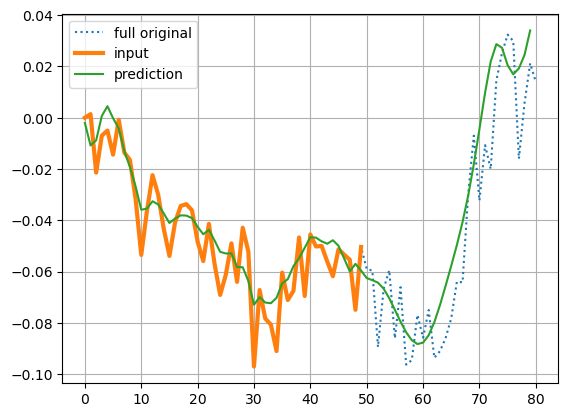

In [139]:
with torch.no_grad():
    future = 30
    pred = model(torch.Tensor(data[2, :50]).unsqueeze(0), look=future)
    y = pred.detach().numpy()
noise = np.random.weibull(250, len(y)) - 1.0
y = y.T + noise
plt.plot(data[2, :], linestyle='dotted', label='full original')
plt.plot(data[2, :50], linewidth=3, label='input')
plt.plot(y, label='prediction')
plt.legend()
plt.grid()